<a href="https://colab.research.google.com/github/Pratichhya/ForestFire/blob/main/ForestFire_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install rasterio

Import libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

import sklearn
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

import rasterio

Read the csv sample data

In [4]:
dataframe=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/ranPtgenerated.csv",delimiter=";")
#statistical distribution of data
statistical= dataframe.describe()
dataframe.head()

,OBJECTID,CID,blue,green,red,nir,swir,GT
0,1,1,380.0,634.0,1004.0,1626.0,2898.0,0.0
1,2,1,248.0,406.0,544.0,1402.0,1328.0,1.0
2,3,1,771.0,1046.0,1396.0,2186.0,2787.0,0.0
3,4,1,585.0,847.0,1124.0,1970.0,3440.0,0.0
4,5,1,1334.0,716.0,837.0,2066.0,1688.0,0.0


Data Preprocessing 

In [5]:
#remove null data
dataframe = dataframe.dropna(how='any',axis=0)

In [6]:
#separation of x and y
x = dataframe.drop(['GT','CID','OBJECTID'], 1)
y = dataframe.iloc[:, -1:]

In [7]:
#convert to numpy array
xx=x.to_numpy()
yy=y.to_numpy().squeeze()
print("shapes,",xx.shape,yy.shape)

shapes, (9995, 5) (9995,)


In [8]:
#split training and testing set from main dataset
x_train,x_test,y_train,y_test = train_test_split(xx,yy,test_size = 0.2)
x_train,x_val,y_train,y_val=train_test_split(x_train,y_train,test_size=0.1)

Using SVM algorithm

checking the SVM performance with default parameters and choosing a specific kernel type

In [9]:
#fit the model with linear kernel
model_linear = SVC(kernel = "linear")
model_linear.fit(x_train,y_train)

#predict
pred_test_linear = model_linear.predict(x_test)
#confusion matrix
print("Confusion matrix for Liner Kernel:")
print(confusion_matrix(y_test, pred_test_linear))
#evaluating linear kernel model
# Model Accuracy: how often is the classifier correct?
print("Accuracy by Linear Kernel:",metrics.accuracy_score(y_test, pred_test_linear))

#fit the model with radial kernel
model_rbf = SVC(kernel = "rbf")
model_rbf.fit(x_train,y_train)

#predict
pred_test_rbf = model_rbf.predict(x_test)
#confusion matrix
print("Confusion matrix for Radial Kernel:")
print(confusion_matrix(y_test, pred_test_rbf))
#evaluating rbf kernel model
# Model Accuracy: how often is the classifier correct?
print("Accuracy by Radial Kernel:",metrics.accuracy_score(y_test, pred_test_rbf))


Confusion matrix for Liner Kernel:
[[823 136]
 [172 868]]
Accuracy by Linear Kernel: 0.8459229614807404
Confusion matrix for Radial Kernel:
[[786 173]
 [ 65 975]]
Accuracy by Radial Kernel: 0.8809404702351176


Taking all the values of C and gamma for checking out the accuracy score with kernel as rbf since rbf has higher accuracy in default

In [12]:
acc_score_rbf_vali=pd.DataFrame(columns=['C','Gamma', 'Overall Accuracy'])
gamma_range=[0.0001,0.001,0.01,0.1]
v=1
for c in range(1,150,1):
  for g in gamma_range:
    svc_vali = SVC(kernel='rbf', C=c, gamma= g)
    score_vali= cross_val_score(svc_vali, x_train, y_train,cv= 2,scoring="accuracy")
    acc_score_rbf_vali.loc[v]=[c,g,score_vali.mean()]
    #acc_score_rbf_vali.append(score_vali.mean())
    v+=1
    
print(acc_score_rbf_vali)

         C   Gamma  Overall Accuracy
1      1.0  0.0001          0.872151
2      1.0  0.0010          0.756392
3      1.0  0.0100          0.513480
4      1.0  0.1000          0.513202
5      2.0  0.0001          0.869928
..     ...     ...               ...
592  148.0  0.1000          0.513202
593  149.0  0.0001          0.849361
594  149.0  0.0010          0.768066
595  149.0  0.0100          0.513341
596  149.0  0.1000          0.513202

[596 rows x 3 columns]


In [13]:
max(acc_score_rbf_vali["Overall Accuracy"])

0.8721511951083936

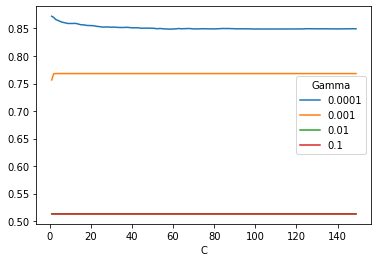

In [14]:
df_acc = acc_score_rbf_vali.pivot(index='C', columns='Gamma', values='Overall Accuracy')
df_acc.plot()

In [ ]:
#acc_score_rbf_vali.plot.line(x="C",y="Overall Accuracy")
#acc_score_rbf_vali.plot.line(x="Gamma",y="Overall Accuracy")

In [15]:
#training rbf model based on c and gamma
#fit the model with radial kernel
model_rbf_vali = SVC(kernel = "rbf", C=1, gamma=0.0001)
model_rbf_vali.fit(x_train,y_train)

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [25]:
#predict
pred_rbf_vali= model_rbf_vali.predict(x_test)
#confusion matrix
print("Confusion matrix for Radial Kernel:")
print(confusion_matrix(y_test, pred_rbf_vali))
#evaluating rbf kernel model
# Model Accuracy: how often is the classifier correct?
print("Accuracy by Radial Kernel:",metrics.accuracy_score(y_test, pred_rbf_vali))

Confusion matrix for Radial Kernel:
[[862  97]
 [136 904]]
Accuracy by Radial Kernel: 0.8834417208604303


Loading the Test Set

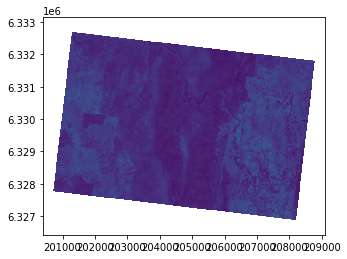

In [16]:
#to load satellite image load it with raster io
from rasterio.plot import show
fp = r'/content/drive/MyDrive/Colab Notebooks/stacked_test_clipped.tif'
img = rasterio.open(fp)
show(img)

In [17]:
blue=img.read(1).flatten()
green=img.read(2).flatten()
red=img.read(3).flatten()
nir=img.read(4).flatten()
swir=img.read(5).flatten()

In [18]:
dataread=img.read()
dataread.shape

(5, 672, 870)

In [19]:
data=np.stack([blue,green,red,nir,swir],axis=1)
data.shape

(584640, 5)

Applying the SVM Model

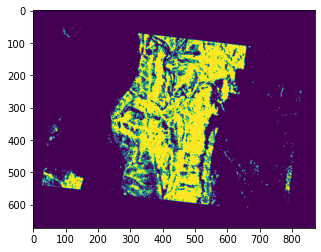

In [20]:
#based on default SVM linear
results_default_linear=model_linear.predict(data)
preds_default_linear=results_default_linear.reshape((672, 870))
import matplotlib.pyplot as plt
plt.imshow(preds_default_linear.astype(int))

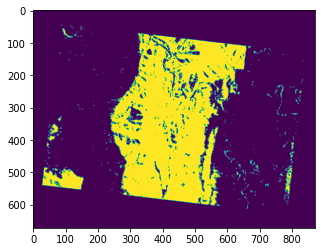

In [21]:
#based on default SVM rbf
results_default=model_rbf.predict(data)
preds_default=results_default.reshape((672, 870))
import matplotlib.pyplot as plt
plt.imshow(preds_default.astype(int))

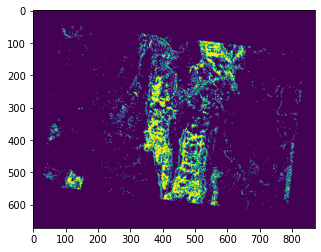

In [22]:
#based on defined c and gamma value
results_vali=model_rbf_vali.predict(data)
preds_vali=results_vali.reshape((672, 870))
import matplotlib.pyplot as plt
plt.imshow(preds_vali.astype(int))

In [28]:
# Register GDAL format drivers and configuration options with a
# context manager.
with rasterio.Env():

    # Write an array as a raster band to a new 8-bit file. For
    # the new file's profile, we start with the profile of the source
    profile = img.profile

    # And then change the band count to 1, set the

    profile.update(
        dtype=rasterio.uint8,
        count=1,
        compress='lzw',
        nodata=0
        )

    with rasterio.open('/content/drive/MyDrive/Colab Notebooks/svmFin_def_linear.tif', 'w', **profile) as dst:
        dst.write(preds_default_linear.astype(rasterio.uint8), 1)
    with rasterio.open('/content/drive/MyDrive/Colab Notebooks/svmFin_def_rbf.tif', 'w', **profile) as dst:
        dst.write(preds_default.astype(rasterio.uint8), 1)
    with rasterio.open('/content/drive/MyDrive/Colab Notebooks/svmFin_vali_rbf.tif', 'w', **profile) as dst:
        dst.write(preds_vali.astype(rasterio.uint8), 1)

Using Random Forest Algorithm 

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

Training and testing with default

In [30]:
clf_default=RandomForestClassifier()
clf_default.fit(x_train, y_train)
y_pred_RF_default=clf_default.predict(x_test)

In [31]:
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_RF_default))
#confusion matrix
print("Confusion matrix for RF:")
print(confusion_matrix(y_test, y_pred_RF_default))

Accuracy: 0.8934467233616809
Confusion matrix for RF:
[[838 121]
 [ 92 948]]


Training the Model with validated output

In [34]:
oobdf=pd.DataFrame(columns=['nestimator','oob'])
j=1
for i in range(1,1001,20):
  #Create a Gaussian Classifier
  clf=RandomForestClassifier(n_estimators=i,oob_score=True,max_depth=10)
  #Train the model using the training sets y_pred=clf.predict(x_test)
  clf.fit(x_train, y_train)
  oob=clf.oob_score_
  oobdf.loc[j]=[i,oob]
  j+=1

oobdf

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


,nestimator,oob
1,1.0,0.624931
2,21.0,0.883407
3,41.0,0.886882
4,61.0,0.888549
5,81.0,0.888688
6,101.0,0.888966
7,121.0,0.888966
8,141.0,0.889661
9,161.0,0.888966
10,181.0,0.888271


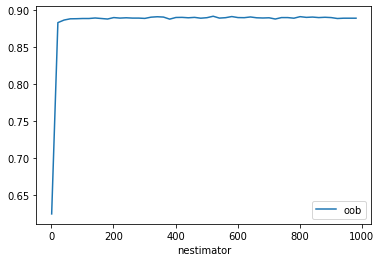

In [35]:
oobdf.plot.line(x="nestimator",y="oob")

In [36]:
#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=521,oob_score=True)
#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=521,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)

In [37]:
y_pred_RF=clf.predict(x_test)

In [38]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_RF))

Accuracy: 0.896448224112056


In [39]:
#confusion matrix
print("Confusion matrix for RF:")
print(confusion_matrix(y_test, y_pred_RF))

Confusion matrix for RF:
[[836 123]
 [ 84 956]]


In [41]:
tp=836
fn=123
fp=84
tn=956
a=(tp/(tp+fp))
b=(tp/(tp+fn)) 
c=((2*a*b)/a+b)
print("precision:", a) 
print("recall:", b)
print("f1:", a)

precision: 0.908695652173913
recall: 0.8717413972888426
f1: 0.908695652173913


Testing on RF

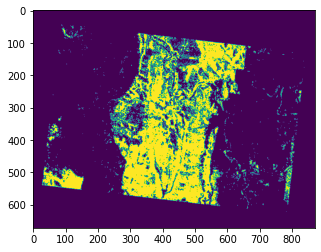

In [42]:
result_RF_default =clf_default.predict(data)
preds_RF_default=result_RF_default.reshape((672, 870))
import matplotlib.pyplot as plt
plt.imshow(preds_RF_default.astype(int))

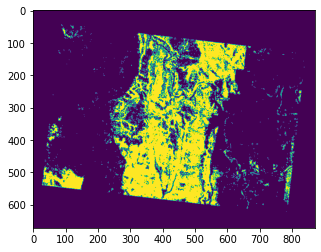

In [43]:
result_RF=clf.predict(data)
preds_RF=result_RF.reshape((672, 870))
import matplotlib.pyplot as plt
plt.imshow(preds_RF.astype(int))

In [44]:
#Register GDAL format drivers and configuration options with a
# context manager.
with rasterio.Env():

    # Write an array as a raster band to a new 8-bit file. For
    # the new file's profile, we start with the profile of the source
    profile = img.profile

    # And then change the band count to 1, set the

    profile.update(
        dtype=rasterio.uint8,
        count=1,
        compress='lzw',
        nodata=0
        )

    with rasterio.open('/content/drive/MyDrive/Colab Notebooks/RF_DefFin.tif', 'w', **profile) as dst:
        dst.write(preds_RF_default.astype(rasterio.uint8), 1)
    with rasterio.open('/content/drive/MyDrive/Colab Notebooks/RF_ValiFin.tif', 'w', **profile) as dst:
        dst.write(preds_RF.astype(rasterio.uint8), 1)


Again for presentation tessting in the same image

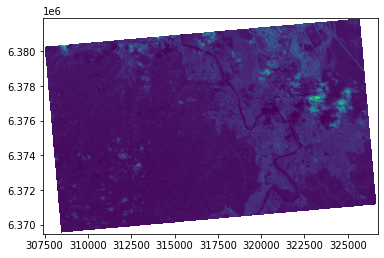

In [45]:
#to load satellite image load it with raster io
from rasterio.plot import show
check = r'/content/drive/MyDrive/Colab Notebooks/clipped_v0.tif'
img_check = rasterio.open(check)
show(img_check)

In [46]:
blue_ck=img_check.read(1).flatten()
green_ck=img_check.read(2).flatten()
red_ck=img_check.read(3).flatten()
nir_ck=img_check.read(4).flatten()
swir_ck=img_check.read(5).flatten()

In [47]:
dataread_check=img_check.read()
dataread_check.shape

(5, 1248, 1932)

In [48]:
data_check=np.stack([blue_ck,green_ck,red_ck,nir_ck,swir_ck],axis=1)
data_check.shape

(2411136, 5)

For Linear SVM
For RBF SVM
For Validated RBF SVM
For RF
For Validated RF


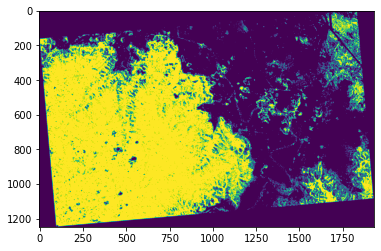

In [49]:
#based on default SVM linear
default_linear_ck=model_linear.predict(data_check)
preds_default_linear_ck=default_linear_ck.reshape((1248, 1932))
import matplotlib.pyplot as plt
print("For Linear SVM")
plt.imshow(preds_default_linear_ck.astype(int))

#based on default SVM rbf
results_default_ck=model_rbf.predict(data_check)
preds_default_ck=results_default_ck.reshape((1248, 1932))
import matplotlib.pyplot as plt
print("For RBF SVM")
plt.imshow(preds_default_ck.astype(int))

#based on defined c and gamma value
results_vali_ck=model_rbf_vali.predict(data_check)
preds_vali_ck=results_vali_ck.reshape((1248, 1932))
import matplotlib.pyplot as plt
print("For Validated RBF SVM")
plt.imshow(preds_vali_ck.astype(int))

result_RF_default_ck=clf_default.predict(data_check)
preds_RF_default_ck=result_RF_default_ck.reshape((1248, 1932))
import matplotlib.pyplot as plt
print("For RF")
plt.imshow(preds_RF_default_ck.astype(int))

result_RF_ck=clf.predict(data_check)
preds_RF_ck=result_RF_ck.reshape((1248, 1932))
import matplotlib.pyplot as plt
print("For Validated RF")
plt.imshow(preds_RF_ck.astype(int))

In [50]:
#Register GDAL format drivers and configuration options with a
# context manager.
with rasterio.Env():

    # Write an array as a raster band to a new 8-bit file. For
    # the new file's profile, we start with the profile of the source
    profile = img.profile

    # And then change the band count to 1, set the

    profile.update(
        dtype=rasterio.uint8,
        count=1,
        compress='lzw',
        nodata=0
        )

    with rasterio.open('/content/drive/MyDrive/Colab Notebooks/svm1.tif', 'w', **profile) as dst:
        dst.write(preds_default_linear_ck.astype(rasterio.uint8), 1)
    with rasterio.open('/content/drive/MyDrive/Colab Notebooks/svm2.tif', 'w', **profile) as dst:
        dst.write(preds_default_ck.astype(rasterio.uint8), 1)
    with rasterio.open('/content/drive/MyDrive/Colab Notebooks/svm3.tif', 'w', **profile) as dst:
        dst.write(preds_vali_ck.astype(rasterio.uint8), 1)
    with rasterio.open('/content/drive/MyDrive/Colab Notebooks/rf1.tif', 'w', **profile) as dst:
        dst.write(preds_RF_default_ck.astype(rasterio.uint8), 1)
    with rasterio.open('/content/drive/MyDrive/Colab Notebooks/rf2.tif', 'w', **profile) as dst:
        dst.write(preds_RF_ck.astype(rasterio.uint8), 1)